In [1]:
import os
os.chdir(os.getcwd() + '/../../')

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.bert_utils import *

# specify GPU
device = torch.device("cuda")

In [3]:
comments = pd.read_csv('data/comments/preprocessed_comments.csv', index_col=0)
comments = comments.dropna()
comments.head()

,toxic,comment_text
0,0,explanation why the edits make under my userna...
1,0,d'aww ! he match this background colour i be s...
2,0,"hey man , i be really not try to edit war . it..."
3,0,`` more i can not make any real suggestion on ...
4,0,"you , sir , be my hero . any chance you rememb..."


In [4]:
temp_text, test_text, temp_labels, test_labels = train_test_split(comments['comment_text'], 
                                                                  comments['toxic'], 
                                                                  random_state=0, 
                                                                  test_size=0.2, 
                                                                  stratify=comments['toxic'])


train_text, val_text, train_labels, val_labels = train_test_split(temp_text, 
                                                                  temp_labels, 
                                                                  random_state=0, 
                                                                  test_size=0.2, 
                                                                  stratify=temp_labels)

In [5]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(0.0, 1000.0)

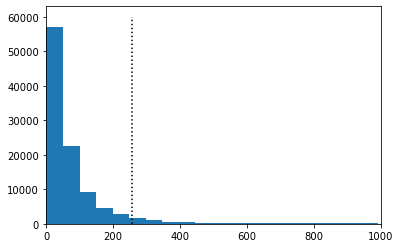

In [6]:
seq_len = [len(i.split()) for i in train_text]
plt.hist(seq_len, bins=100)
plt.vlines(256, 0, 60000, linestyles='dotted', color='k')
plt.xlim(0, 1000)

In [7]:
n_tokens = 128

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = n_tokens,
    padding='max_length',
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = n_tokens,
    padding='max_length',
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = n_tokens,
    padding='max_length',
    truncation=True
)

In [8]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [9]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [10]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = True

In [11]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
        super(BERT_Arch, self).__init__()

        self.bert = bert 
      
        # dropout layer
        self.dropout = nn.Dropout(0.1)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
      
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

        #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
        
        # apply softmax activation
        x = self.softmax(x)
  
        return x


In [12]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [13]:
#load weights of best model
path = 'models/bert_v3.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [14]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-7)          # learning rate

In [15]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', y=train_labels, classes=np.unique(train_labels))

print("Class Weights:",class_weights)

Class Weights: [0.55300208 5.21679608]


In [16]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [17]:
# function to train the model
def train(model, train_dataloader, loss_function):

    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
  
    # iterate over batches
    for step, batch in enumerate(train_dataloader):
    
        # progress update after every 50 batches.
        if step % 100 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]
 
        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = loss_function(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [18]:
# function for evaluating the model
def evaluate():
  
    print("\nEvaluating...")
  
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
  
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):
            
        # progress update after every 50 batches.
        if step % 100 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
      
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [19]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train(model, train_dataloader, cross_entropy)
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'models/bert_v3c.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch   100  of  6,383.
  Batch   200  of  6,383.
  Batch   300  of  6,383.
  Batch   400  of  6,383.
  Batch   500  of  6,383.
  Batch   600  of  6,383.
  Batch   700  of  6,383.
  Batch   800  of  6,383.
  Batch   900  of  6,383.
  Batch 1,000  of  6,383.
  Batch 1,100  of  6,383.
  Batch 1,200  of  6,383.
  Batch 1,300  of  6,383.
  Batch 1,400  of  6,383.
  Batch 1,500  of  6,383.
  Batch 1,600  of  6,383.
  Batch 1,700  of  6,383.
  Batch 1,800  of  6,383.
  Batch 1,900  of  6,383.
  Batch 2,000  of  6,383.
  Batch 2,100  of  6,383.
  Batch 2,200  of  6,383.
  Batch 2,300  of  6,383.
  Batch 2,400  of  6,383.
  Batch 2,500  of  6,383.
  Batch 2,600  of  6,383.
  Batch 2,700  of  6,383.
  Batch 2,800  of  6,383.
  Batch 2,900  of  6,383.
  Batch 3,000  of  6,383.
  Batch 3,100  of  6,383.
  Batch 3,200  of  6,383.
  Batch 3,300  of  6,383.
  Batch 3,400  of  6,383.


KeyboardInterrupt: 

In [ ]:
df_plot = pd.DataFrame()
df_plot['train_loss'] = train_losses
df_plot['valid_loss'] = valid_losses
df_plot['epoch'] = range(1+10, epochs+1+10)
df_plot.to_csv('results/bert_v3c.csv')

sns.lineplot(x='epoch', 
             y='value', 
             data=pd.melt(df_plot.reset_index(), 
                          id_vars='epoch', 
                          value_vars=['train_loss', 'valid_loss']),
             hue='variable')
plt.ylabel('cross entropy loss')
plt.title('BERT, frozen parameters')